### Introduction to **Causica** by Microsoft

**Causica** is a powerful library developed by Microsoft for performing **causal inference** within machine learning frameworks. Its primary purpose is to estimate **causal relationships** between variables in complex systems, helping researchers and data scientists understand the impact of one variable on another — beyond mere correlation.

Unlike traditional machine learning models, which focus on predicting outcomes, **Causica** enables you to identify and quantify the **cause-and-effect relationships** between variables. This is crucial for applications like marketing optimization, treatment effect estimation, and policy evaluation, where understanding the **true impact** of interventions (e.g., marketing spends, drug treatments, etc.) is key.

### Key Features:
- **Causal Graphs**: Causica uses **causal graphs** to model relationships and allow for effective counterfactual reasoning.
- **Counterfactual Estimation**: By leveraging **Structural Equation Models (SEMs)**, it estimates what would have happened had a different intervention been applied.
- **Flexibility**: It can be applied to a wide range of problems, including treatment effect estimation (e.g., estimating the effect of a marketing campaign on sales).
- **Uncertainty Quantification**: Provides statistical uncertainty around causal estimates, such as **posterior distributions**.

### Why Causica?
1. **Robust Causal Inference**: Causica allows you to work with **stochastic SEM sampling**, enabling robust estimates of causal relationships under uncertainty.
2. **Real-World Relevance**: Causica is designed to work in real-world applications, especially where **multi-variable** and **non-linear** relationships are common.
3. **Reproducibility**: By fixing seeds and controlling randomness, Causica ensures that results can be **reproduced**, critical for both academic and applied work.

In essence, Causica is an essential tool for anyone interested in understanding the **causal dynamics** in their data, whether it's in economics, healthcare, marketing, or other fields that require decision-making based on causal effects rather than simple correlations.

load libraries (You may not need all of them)

In [1]:
import sys
print(sys.version)

3.10.16 (main, Dec 11 2024, 10:22:29) [Clang 14.0.6 ]


In [2]:
# Core components
!git clone https://github.com/microsoft/causica.git
%cd causica
!pip install -e .


fatal: destination path 'causica' already exists and is not an empty directory.
/Users/paulfagan/causica/causica


/Users/paulfagan/anaconda3/envs/Causica/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


Obtaining file:///Users/paulfagan/causica/causica
  Installing build dependencies ... one
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for causica (pyproject.toml) ... done
  Created wheel for causica: filename=causica-0.4.5-py3-none-any.whl size=5361 sha256=1218b9517722a288307e3066fdaccc38c7a44fd05f8ccf03c33b402b8fb77981
  Stored in directory: /private/var/folders/nf/4wc9544n4vn1fsh67xg05_kh0000gn/T/pip-ephem-wheel-cache-1dbba1ri/wheels/9d/31/cd/dd8f2d4855a7da5cc94f5d388f3a7625a2b71e40f0214c4f5c
Successfully built causica
  Attempting uninstall: causica
    Found existing installation: causica 0.4.5
    Uninstalling causica-0.4.5:
      Successfully uninstalled causica-0.4.5


In [3]:
!pip install causica


USER MANUAL



# 📘 Causica Interventions Reference Table

| Section | Description | Example / Notes |
|--------|-------------|------------------|
| **🎯 Purpose** | Estimate **ATE/ITE** from observational data using simulated interventions. | Useful for marketing attribution, what-if scenarios. |
| **🧠 Key Concepts** | - **Intervention**: set a variable<br>- **Treatment**: manipulated input (e.g., `tv`, `fb`)<br>- **Outcome**: observed result (e.g., `rev`)<br>- **SEM**: structural equation model | `TensorDict({\"tv\": torch.tensor([1.0])}, batch_size=tuple())` |
| **🔧 Basic Syntax** | **Single**: `sem.do({\"tv\": 1.0})`<br>**Multi**: `sem.do({\"tv\": 1.0, \"fb\": 0.5})` | Always use `batch_size=tuple()` |
| **📊 ATE Estimation** | Compare simulated outcomes under ON vs OFF treatment: | ```python\nsamples_on = sem.do(on).sample()\nsamples_off = sem.do(off).sample()\ndiff = samples_on['rev'] - samples_off['rev']\nate = diff.mean()\n``` |
| **👤 ITE Estimation** | Use real data noise for individual-level effects: | ```python\nbase_noise = sem.sample_to_noise(train_data)\ncf_on = sem.do(on).noise_to_sample(base_noise)\ncf_off = sem.do(off).noise_to_sample(base_noise)\nite = cf_on['rev'] - cf_off['rev']\n``` |
| **🔁 Posterior ATE Loop** | Sample multiple SEMs for uncertainty-aware ATE: | ```python\nate_samples = []\nfor _ in range(50):\n  sem = model.sem_module().relaxed_sample(...)[0]\n  diff = sem.do(...)\n  ate_samples.append(diff.mean())\n``` |
| **🧾 Summary** | Intervene with `TensorDict`<br>Compare ON vs OFF<br>Loop SEMs for posterior inference<br>Use `.sample()` or `.noise_to_sample()` depending on your use case | You can now answer: _“What if we spent more on Facebook?”_ |


# 🧩 SEM Constraint Matrix Reference

| Section | Description | Example / Notes |
|---------|-------------|------------------|
| **🎯 Purpose** | Restrict edges in the learned causal graph using domain knowledge. | Prevent revenue → spend loops. |
| **🧠 Matrix Values** | `0.0` → **forbidden** edge<br>`np.nan` → **unconstrained** edge<br>`1.0` (optional) → enforced edge | Most edges should be `np.nan` unless constrained. |
| **🔢 Shape** | Square matrix of shape *(n_variables x n_variables)* | Rows: sources, Columns: targets |
| **🧭 Creation Strategy** | 1. Map `var.name` to index<br>2. Assign values based on logic<br>3. Convert to PyTorch tensor | Use `torch.tensor(..., dtype=torch.float32)` |
| **🔒 Common Rules** | - Block **all outgoing** from outcome (e.g. `rev`)<br>- Forbid X → Y if causality is illogical | `constraint_matrix[rev_idx, :] = 0.0` |
| **🛠 Assigning to Model** | ```python\nmodel.constraint_matrix = torch.tensor(constraint_matrix).float().to(\"cpu\")\n``` | Set before calling `Trainer.fit(...)` |
| **🧯 Debugging Tips** | 🔹 Shape mismatch → check `n_vars`<br>🔹 Wrong keys → double-check `var.name` ↔ column names<br>🔹 Unused constraint → ensure it’s assigned to model | Use `.shape` and `.dtype` to inspect |
| **✅ Best Practices** | ✔ Use group names (`tv`, `rev`) consistently<br>✔ Keep matrix mostly unconstrained unless necessary<br>✔ Visualize with `matshow()` or `heatmap()` | Overconstraining may block valid structure learning |
| **📊 Visualization** | ```python\nimport matplotlib.pyplot as plt\nplt.matshow(constraint_matrix.numpy(), cmap='coolwarm')\nplt.title(\"Constraint Matrix\")\nplt.show()\n``` | Helps visually debug |
| **🧾 Summary** | Constraint matrices encode prior knowledge and improve realism of learned graphs. Use carefully. | Don't constrain unless you're sure! |

In [5]:
import os
from operator import itemgetter
import warnings

import fsspec
import json
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import torch


from pytorch_lightning.callbacks import TQDMProgressBar
from tensordict import TensorDict

from causica.datasets.causica_dataset_format import CAUSICA_DATASETS_PATH, Variable
from causica.distributions import ContinuousNoiseDist
from causica.lightning.data_modules.basic_data_module import BasicDECIDataModule
from causica.lightning.modules.deci_module import DECIModule
from causica.sem.sem_distribution import SEMDistributionModule
from causica.sem.structural_equation_model import ite
from causica.training.auglag import AugLagLRConfig

warnings.filterwarnings("ignore")
test_run = bool(os.environ.get("TEST_RUN", False))  # used by testing to run the notebook as a script

In [6]:
import pandas as pd
import numpy as np
import networkx as nx
import torch
from causica.datasets.variable_types import VariableTypeEnum
from causica.datasets.causica_dataset_format.load import Variable
from causica.lightning.data_modules.basic_data_module import BasicDECIDataModule
from causica.lightning.modules.deci_module import DECIModule
from causica.sem.structural_equation_model import ite
from causica.distributions.noise.joint import ContinuousNoiseDist
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import TQDMProgressBar

In [7]:
# 1. Load your data
data = pd.read_csv("/Users/paulfagan/masters_daily_level_dataset_rev50.csv")
data.dropna(inplace=True)
data

,DATE,total_revenue,impressions_Facebook,impressions_TV,clicks_Search,spend_Facebook,spend_TV,spend_Search
0,2022-01-01,1.358523e+06,3.824642e+07,1.600046e+06,280549.963908,114680.842165,32375.015585,69591.401058
1,2022-01-02,1.452514e+06,5.427171e+07,1.698688e+06,518514.513937,162944.373281,34125.333525,139917.747690
2,2022-01-03,8.749671e+05,2.430909e+07,1.092894e+06,233745.032889,73015.123190,22068.931648,60015.388576
3,2022-01-04,2.298839e+06,6.988770e+07,2.810008e+06,544753.635477,209703.601322,56121.861860,137107.959660
4,2022-01-05,7.204442e+06,4.920042e+07,1.990612e+06,448406.220010,146433.033258,39747.024278,124405.498262
...,...,...,...,...,...,...,...,...
725,2023-12-27,1.516878e+06,3.560749e+07,1.542009e+06,306146.273092,106642.337990,30857.407750,78613.949643
726,2023-12-28,2.249652e+06,5.713911e+07,1.938072e+06,561448.875998,170716.566286,39399.297650,151048.549444
727,2023-12-29,2.987774e+06,3.417130e+07,1.247456e+06,380092.328142,103025.328503,25193.649453,95011.207834
728,2023-12-30,4.111113e+06,6.480867e+07,2.754442e+06,574431.926870,193929.579473,55073.416166,154374.904154


Default Basic Model

INFO:torch.distributed.nn.jit.instantiator:Created a temporary directory at /var/folders/nf/4wc9544n4vn1fsh67xg05_kh0000gn/T/tmp7_3c8f5f
INFO:torch.distributed.nn.jit.instantiator:Writing /var/folders/nf/4wc9544n4vn1fsh67xg05_kh0000gn/T/tmp7_3c8f5f/_remote_module_non_scriptable.py
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name        | Type                  | Params
------------------------------------------------------
0 | auglag_loss | AugLagLossCalculator  | 0     
1 | sem_module  | SEMDistributionModule | 18.0 K
------------------------------------------------------
18.0 K    Trainable params
16        Non-trainable params
18.0 K    Total params
0.072     Total estimated model params size (MB)


Updating alpha to: 1.1862878799438477:00<00:00, 51.29it/s, v_num=25]
Updating rho, dag penalty prev:  1.18628787990, 84.94it/s, v_num=25]
Updating rho, dag penalty prev:  1.1862878799, 89.91it/s, v_num=25] 
Updating rho, dag penalty prev:  1.1862878799, 92.62it/s, v_num=25] 
Updating rho, dag penalty prev:  1.1862878799, 93.09it/s, v_num=25] 
Epoch 999: 100%|██████████| 11/11 [00:00<00:00, 90.01it/s, v_num=25]

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 999: 100%|██████████| 11/11 [00:00<00:00, 85.85it/s, v_num=25]


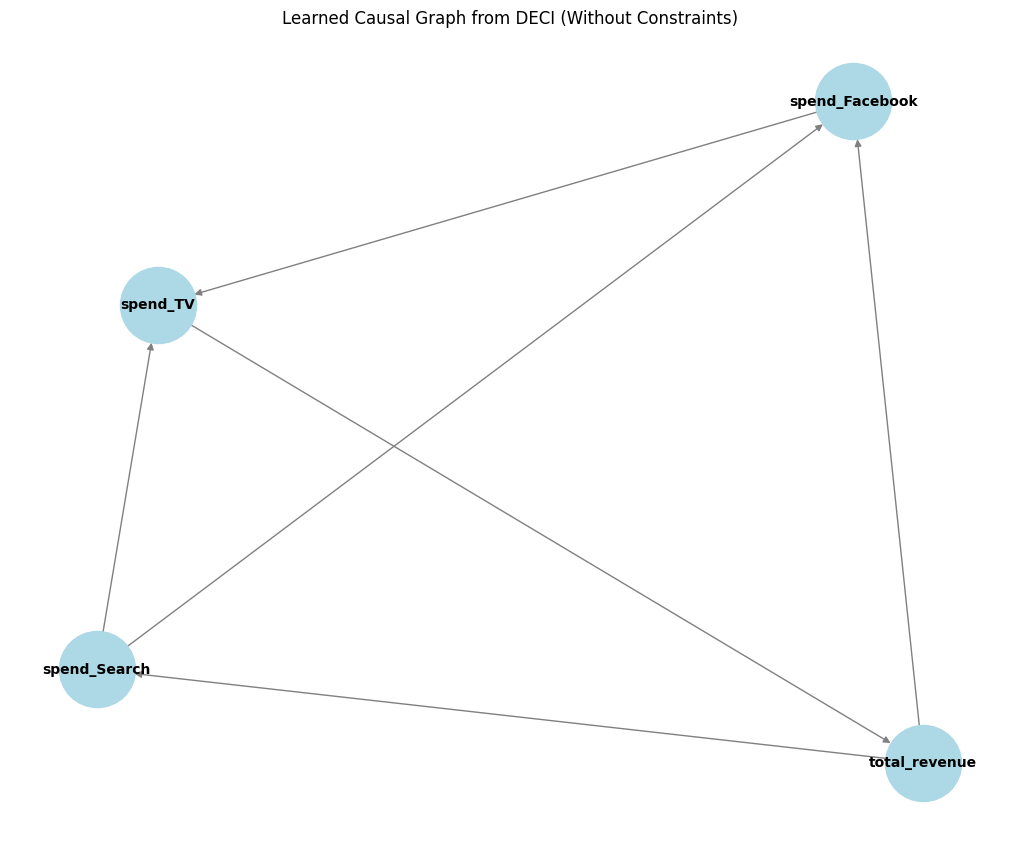

Learned Edges:
spend_TV → total_revenue
spend_Facebook → spend_TV
spend_Search → spend_TV
spend_Search → spend_Facebook
total_revenue → spend_Facebook
total_revenue → spend_Search


In [5]:
# 1. Load your data
data = pd.read_csv("/Users/paulfagan/masters_daily_level_dataset_rev50.csv")
data.dropna(inplace=True)

# 2. Define your variables with unique group names
variables = [
    Variable(group_name="tv", name="spend_TV", type=VariableTypeEnum.CONTINUOUS),
    Variable(group_name="fb", name="spend_Facebook", type=VariableTypeEnum.CONTINUOUS),
    Variable(group_name="search", name="spend_Search", type=VariableTypeEnum.CONTINUOUS),
    Variable(group_name="rev", name="total_revenue", type=VariableTypeEnum.CONTINUOUS),
]

# 3. Prepare the subset of data for analysis
subset_data = data[["spend_TV", "spend_Facebook", "spend_Search", "total_revenue"]]

# 4. Create the DataModule
data_module = BasicDECIDataModule(
    dataframe=subset_data,
    variables=variables,
    batch_size=64,
    normalize=True,
    dataset_name='marketing_spend_analysis'
)

# 5. Initialize the model with the correct noise distribution
model = DECIModule(
    noise_dist=ContinuousNoiseDist.SPLINE,
    embedding_size=32,
    out_dim_g=32,
    num_layers_g=2,
    num_layers_zeta=2,
    prior_sparsity_lambda=0.05,
    gumbel_temp=0.25,
)

# 6. Configure the model with variables
model.variables = variables
model.num_vars = len(variables)

# Note: Removed the constraint matrix completely
# This allows the model to discover causal relationships freely

# 7. Train the model
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import TQDMProgressBar

trainer = Trainer(
    max_epochs=1000,
    accelerator="cpu",  # or use GPU if available and supported
    callbacks=[TQDMProgressBar()]
)
trainer.fit(model, data_module)

# 8. Visualize the learned causal graph
# Get the most likely SEM from the distribution
sem = model.sem_module().mode  # .mode returns a single adjacency matrix

# Convert adjacency matrix to a DiGraph
# Important: Use a threshold to convert continuous adjacency values to binary
adj_matrix = sem.graph.cpu().numpy()
threshold = 0.1  # Adjust this threshold to control edge sparsity
binary_adj_matrix = (np.abs(adj_matrix) > threshold).astype(int)

# Create DiGraph from binary adjacency matrix
graph = nx.from_numpy_array(binary_adj_matrix, create_using=nx.DiGraph)

# Relabel nodes to your variable names
column_names = list(subset_data.columns)
mapping = dict(enumerate(column_names))
graph = nx.relabel_nodes(graph, mapping)

# Create a layout and plot
plt.figure(figsize=(10, 8))
try:
    # Preferred: use graphviz layout if available
    layout = nx.nx_agraph.graphviz_layout(graph, prog='dot')
except ImportError:
    # Fallback to spring layout
    layout = nx.spring_layout(graph, seed=42)

# Draw the graph
nx.draw(graph, 
        layout, 
        with_labels=True, 
        node_color='lightblue', 
        node_size=3000, 
        font_size=10, 
        font_weight='bold', 
        arrows=True, 
        edge_color='gray')
plt.title("Learned Causal Graph from DECI (Without Constraints)")
plt.tight_layout()
plt.show()

# Optional: Print out the learned edges
print("Learned Edges:")
for edge in graph.edges():
    print(f"{edge[0]} → {edge[1]}")

Refined version

INFO:torch.distributed.nn.jit.instantiator:Created a temporary directory at /var/folders/nf/4wc9544n4vn1fsh67xg05_kh0000gn/T/tmpuqj4kihe
INFO:torch.distributed.nn.jit.instantiator:Writing /var/folders/nf/4wc9544n4vn1fsh67xg05_kh0000gn/T/tmpuqj4kihe/_remote_module_non_scriptable.py
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /Users/paulfagan/causica/causica/lightning_logs

  | Name        | Type                  | Params
------------------------------------------------------
0 | auglag_loss | AugLagLossCalculator  | 0     
1 | sem_module  | SEMDistributionModule | 18.0 K
------------------------------------------------------
18.0 K    Trainable params
16        Non-trainable params
18.0 K    Total params
0.072     Total estimated model params size (MB)


Updating alpha to: 0.0████| 11/11 [00:00<00:00, 63.26it/s, v_num=0]
Updating alpha to: 0.0    | 2/11 [00:00<00:00, 61.61it/s, v_num=0] 
Updating alpha to: 0.0████| 11/11 [00:00<00:00, 67.35it/s, v_num=0]
Updating alpha to: 0.0    | 2/11 [00:00<00:00, 63.84it/s, v_num=0] 
Updating alpha to: 0.0    | 1/11 [00:00<00:00, 70.47it/s, v_num=0] 
Epoch 827:  73%|███████▎  | 8/11 [00:00<00:00, 58.62it/s, v_num=0] 


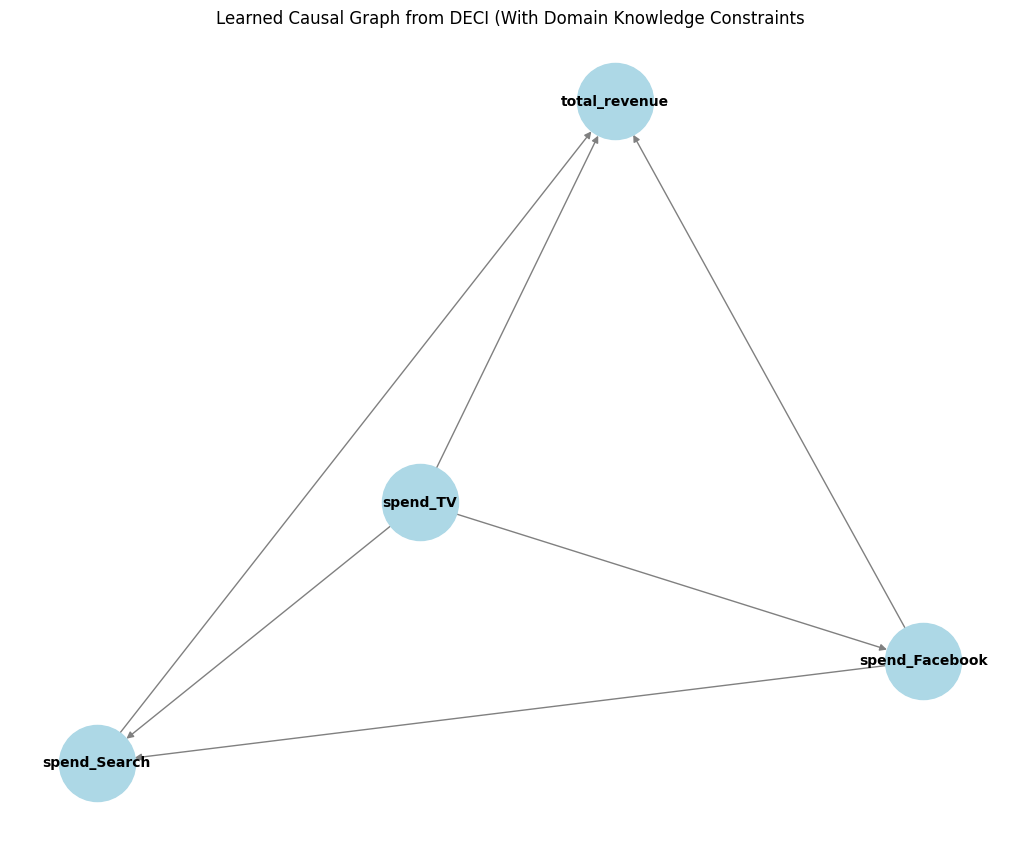

Learned Edges:
spend_TV → spend_Facebook
spend_TV → spend_Search
spend_TV → total_revenue
spend_Facebook → spend_Search
spend_Facebook → total_revenue
spend_Search → total_revenue


In [8]:
# 1. Load your data
data = pd.read_csv("/Users/paulfagan/masters_daily_level_dataset_rev50.csv")
data.dropna(inplace=True)

# 2. Define your variables with unique group names
variables = [
    Variable(group_name="tv", name="spend_TV", type=VariableTypeEnum.CONTINUOUS),
    Variable(group_name="fb", name="spend_Facebook", type=VariableTypeEnum.CONTINUOUS),
    Variable(group_name="search", name="spend_Search", type=VariableTypeEnum.CONTINUOUS),
    Variable(group_name="rev", name="total_revenue", type=VariableTypeEnum.CONTINUOUS),
]

# 3. Prepare the subset of data for analysis
subset_data = data[["spend_TV", "spend_Facebook", "spend_Search", "total_revenue"]]

# 4. Create the DataModule
data_module = BasicDECIDataModule(
    dataframe=subset_data,
    variables=variables,
    batch_size=64,
    normalize=True,
    dataset_name='marketing_spend_analysis'
)

# 5. Initialize the model with the correct noise distribution
model = DECIModule(
    noise_dist=ContinuousNoiseDist.SPLINE,
    embedding_size=32,
    out_dim_g=32,
    num_layers_g=2,
    num_layers_zeta=2,
    prior_sparsity_lambda=0.05,
    gumbel_temp=0.25,
)

# 6. Configure the model with variables
model.variables = variables
model.num_vars = len(variables)

# 6b. Add constraint matrix for both revenue and TV-Facebook constraints
var_name_to_idx = {var.name: idx for idx, var in enumerate(variables)}
num_vars = len(variables)
constraint_matrix = np.full((num_vars, num_vars), np.nan)

# Forbid total_revenue from causing any variable
revenue_idx = var_name_to_idx["total_revenue"]
constraint_matrix[revenue_idx, :] = 0.0

# Add constraint for TV → Facebook but not Facebook → TV
tv_idx = var_name_to_idx["spend_TV"]
fb_idx = var_name_to_idx["spend_Facebook"]
# Allow TV to influence Facebook (leave as np.nan)
# Forbid Facebook from influencing TV
constraint_matrix[fb_idx, tv_idx] = 0.0

# Forbid self-loops (optional but good practice)
for i in range(num_vars):
    constraint_matrix[i, i] = 0.0

# Assign the constraint matrix to the model
model.constraint_matrix = torch.tensor(constraint_matrix, dtype=torch.float32).to('cpu')

# 7. Train the model
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import TQDMProgressBar

trainer = Trainer(
    max_epochs=1000,
    accelerator="cpu",  # or use GPU if available and supported
    callbacks=[TQDMProgressBar()]
)
trainer.fit(model, data_module)

# 8. (Optional) Define a hand-crafted causal graph for reference (not used in graph visualization)
causal_graph = nx.DiGraph([
    ("spend_TV", "spend_Facebook"),
    ("spend_TV", "spend_Search"),
    ("spend_Facebook", "spend_Search"),
    ("spend_Facebook", "total_revenue"),
    ("spend_Search", "total_revenue"),
    ("spend_TV", "total_revenue"),
])

# Get the most likely SEM from the distribution
sem = model.sem_module().mode  # .mode returns a single adjacency matrix

# Convert adjacency matrix to a DiGraph
# Important: Use a threshold to convert continuous adjacency values to binary
adj_matrix = sem.graph.cpu().numpy()
threshold = 0.1  # Adjust this threshold to control edge sparsity
binary_adj_matrix = (np.abs(adj_matrix) > threshold).astype(int)

# Create DiGraph from binary adjacency matrix
graph = nx.from_numpy_array(binary_adj_matrix, create_using=nx.DiGraph)

# Relabel nodes to your variable names
column_names = list(subset_data.columns)
mapping = dict(enumerate(column_names))
graph = nx.relabel_nodes(graph, mapping)

# Create a layout and plot
plt.figure(figsize=(10, 8))
try:
    # Preferred: use graphviz layout if available
    layout = nx.nx_agraph.graphviz_layout(graph, prog='dot')
except ImportError:
    # Fallback to spring layout
    layout = nx.spring_layout(graph, seed=42)

# Draw the graph
nx.draw(graph, 
        layout, 
        with_labels=True, 
        node_color='lightblue', 
        node_size=3000, 
        font_size=10, 
        font_weight='bold', 
        arrows=True, 
        edge_color='gray')

plt.title("Learned Causal Graph from DECI (With Domain Knowledge Constraints")
plt.tight_layout()
plt.show()

# Optional: Print out the edges to see the learned connections
print("Learned Edges:")
for edge in graph.edges():
    print(f"{edge[0]} → {edge[1]}")

INDIVIDUAL TREATMENT EFFECTS

In [29]:
def calculate_ite(
    sem, 
    data_module, 
    treatment_columns, 
    outcome='rev', 
    treatment_values=(1.0, 0.0)
):
    """
    Individualized Treatment Effects (ITE) calculation with group name mapping
    """
    # Map full variable names to group names
    variable_map = {
        "spend_TV": "tv", 
        "spend_Facebook": "fb", 
        "spend_Search": "search", 
        "total_revenue": "rev"
    }
    
    # Convert treatment columns to group names
    treatment_groups = [variable_map[col] for col in treatment_columns]
    outcome_group = variable_map.get(outcome, outcome)
    
    normalizer = data_module.normalizer
    base_noise = sem.sample_to_noise(data_module.dataset_train)
    
    estimated_ite = {}
    
    for treatment, treatment_group in zip(treatment_columns, treatment_groups):
        # Do-intervention with first and second treatment values
        do_sem_a = sem.do(
            interventions=TensorDict(
                {treatment_group: torch.tensor([treatment_values[0]])}, 
                batch_size=tuple()
            )
        )
        do_sem_b = sem.do(
            interventions=TensorDict(
                {treatment_group: torch.tensor([treatment_values[1]])}, 
                batch_size=tuple()
            )
        )
        
        # Generate counterfactuals
        do_a_cfs = normalizer.inv(do_sem_a.noise_to_sample(base_noise))[outcome_group].cpu().detach().numpy()[:, 0]
        do_b_cfs = normalizer.inv(do_sem_b.noise_to_sample(base_noise))[outcome_group].cpu().detach().numpy()[:, 0]
        
        # Calculate treatment effect
        estimated_ite[treatment] = do_a_cfs - do_b_cfs
    
    # Comprehensive results
    print("Estimated Treatment Effects on Revenue:")
    for treatment, effect in estimated_ite.items():
        print(f"{treatment}:")
        print(f"  Mean Effect: {effect.mean()}")
        print(f"  Std Dev: {effect.std()}")
        print(f"  95% CI: [{effect.mean() - 1.96 * effect.std()}, {effect.mean() + 1.96 * effect.std()}]")
    
    return estimated_ite

# Calculate Treatment Effects
treatment_columns = ["spend_TV", "spend_Facebook", "spend_Search"]
revenue_estimated_ite = calculate_ite(sem, data_module, treatment_columns)

Estimated Treatment Effects on Revenue:
spend_TV:
  Mean Effect: 715971.125
  Std Dev: 413584.75
  95% CI: [-94654.98499999999, 1526597.2349999999]
spend_Facebook:
  Mean Effect: 440797.53125
  Std Dev: 77649.640625
  95% CI: [288604.235625, 592990.826875]
spend_Search:
  Mean Effect: 230628.96875
  Std Dev: 299613.9375
  95% CI: [-356614.34875, 817872.28625]


Estimated Treatment Effects on Revenue:
spend_TV:
  Mean Effect: 715971.125
  Std Dev: 413584.75
  95% CI: [-94654.98499999999, 1526597.2349999999]
spend_Facebook:
  Mean Effect: 440797.53125
  Std Dev: 77649.640625
  95% CI: [288604.235625, 592990.826875]
spend_Search:
  Mean Effect: 230628.96875
  Std Dev: 299613.9375
  95% CI: [-356614.34875, 817872.28625]


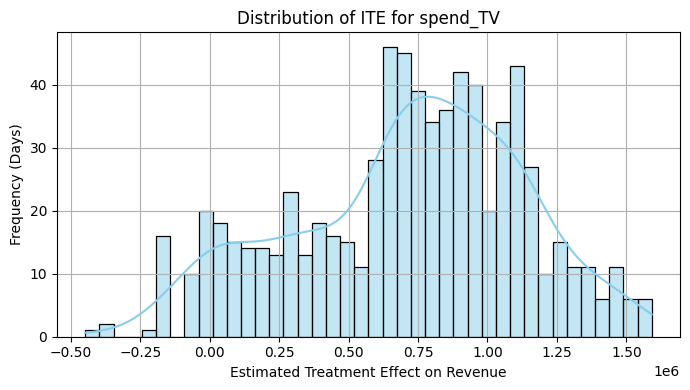

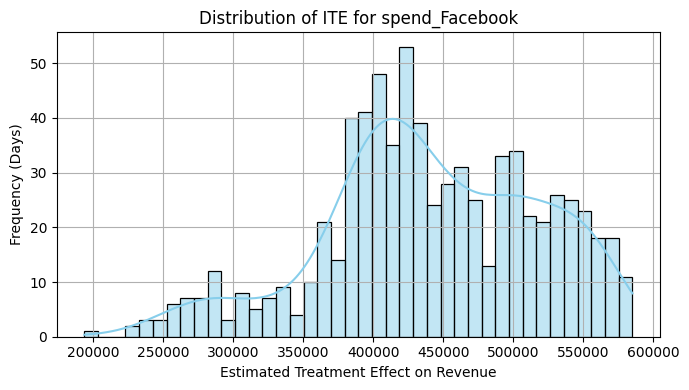

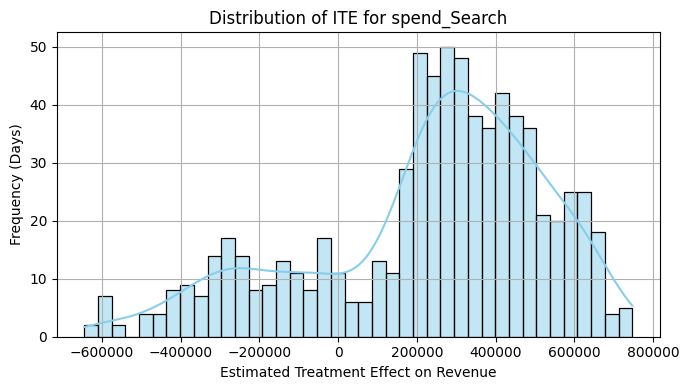

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use the calculated ITEs
revenue_ite = calculate_ite(sem, data_module, ["spend_TV", "spend_Facebook", "spend_Search"])

# Plot each ITE distribution
for treatment, ite_array in revenue_ite.items():
    plt.figure(figsize=(7, 4))
    sns.histplot(ite_array, bins=40, kde=True, color='skyblue', edgecolor='black')
    plt.title(f"Distribution of ITE for {treatment}")
    plt.xlabel("Estimated Treatment Effect on Revenue")
    plt.ylabel("Frequency (Days)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Simple code verison

In [21]:
def calculate_simple_ite(sem, data_module, treatment_groups, outcome_group="rev", treatment_values=(1.0, 0.0)):
    """
    Simple and clean ITE estimation using group names directly.
    """
    normalizer = data_module.normalizer
    base_noise = sem.sample_to_noise(data_module.dataset_train)
    
    estimated_ite = {}
    
    for group in treatment_groups:
        do_on = sem.do(TensorDict({group: torch.tensor([treatment_values[0]])}, batch_size=tuple()))
        do_off = sem.do(TensorDict({group: torch.tensor([treatment_values[1]])}, batch_size=tuple()))

        out_on = normalizer.inv(do_on.noise_to_sample(base_noise))[outcome_group].detach().cpu().numpy()[:, 0]
        out_off = normalizer.inv(do_off.noise_to_sample(base_noise))[outcome_group].detach().cpu().numpy()[:, 0]
        
        effect = out_on - out_off
        estimated_ite[group] = effect

        print(f"{group}: Mean = {effect.mean():.2f}, 95% CI = [{effect.mean() - 1.96 * effect.std():.2f}, {effect.mean() + 1.96 * effect.std():.2f}]")
    
    return estimated_ite

# Use it directly with group names
treatment_groups = ["tv", "fb", "search"]
revenue_ite = calculate_simple_ite(sem, data_module, treatment_groups)

tv: Mean = 715971.12, 95% CI = [-94654.98, 1526597.23]
fb: Mean = 440797.53, 95% CI = [288604.24, 592990.83]
search: Mean = 230628.97, 95% CI = [-356614.35, 817872.29]


INDIVIDUAL TREATMENT EFFECTS

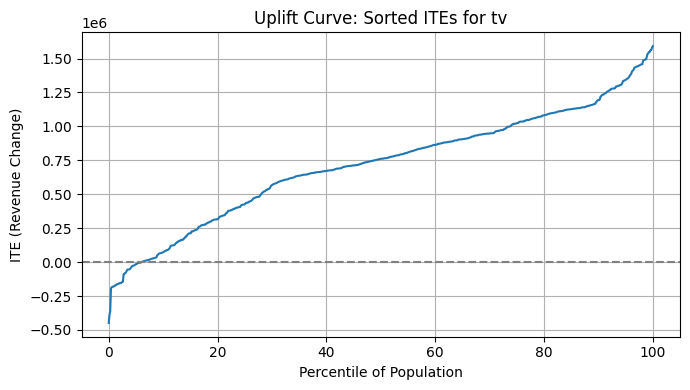

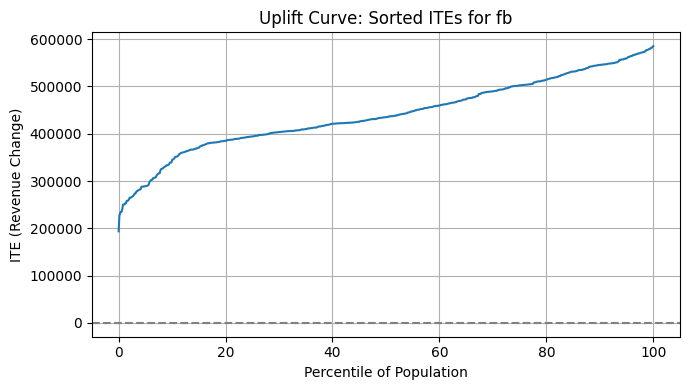

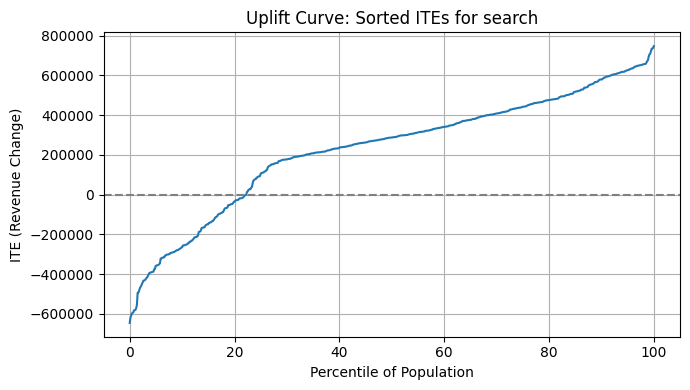

In [22]:
import numpy as np

for treatment, ite_array in revenue_ite.items():
    sorted_effects = np.sort(ite_array)
    percentiles = np.linspace(0, 100, len(sorted_effects))
    
    plt.figure(figsize=(7, 4))
    plt.plot(percentiles, sorted_effects)
    plt.axhline(0, color='gray', linestyle='--')
    plt.title(f"Uplift Curve: Sorted ITEs for {treatment}")
    plt.xlabel("Percentile of Population")
    plt.ylabel("ITE (Revenue Change)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [33]:
print(revenue_ite.keys())

dict_keys(['spend_TV', 'spend_Facebook', 'spend_Search'])


In [34]:
import numpy as np
import pandas as pd

# Pick the group you want to analyze
group = "spend_TV"    # Or "fb", "search"

# Step 1: Get the ITEs
ites = revenue_ite[group]  # Shape (n_days,)

# Step 2: Sort indices by ITE value
sorted_indices = np.argsort(ites)

# Step 3: Identify top and bottom 10 days
top_10_indices = sorted_indices[-10:]
bottom_10_indices = sorted_indices[:10]

# Step 4: Attach ITEs to your original dataset
data_with_ite = data.copy()
data_with_ite[f"ITE_{group}"] = ites

# Step 5: Show top 10 high uplift days
print(f"🔥 Top 10 Days by ITE for '{group}':")
print(data_with_ite.iloc[top_10_indices].sort_values(by=f"ITE_{group}", ascending=False))

# Step 6: Show bottom 10 negative uplift days
print(f"⚠️ Bottom 10 Days by ITE for '{group}':")
print(data_with_ite.iloc[bottom_10_indices].sort_values(by=f"ITE_{group}", ascending=True))

🔥 Top 10 Days by ITE for 'spend_TV':
           DATE  total_revenue  impressions_Facebook  impressions_TV  \
226  2022-08-15   4.665836e+06          6.851710e+07    2.461790e+06   
217  2022-08-06   3.929872e+06          6.648990e+07    2.426267e+06   
519  2023-06-04   1.612259e+06          5.962640e+07    2.055010e+06   
551  2023-07-06   1.774006e+06          5.177206e+07    1.628035e+06   
690  2023-11-22   6.732235e+06          6.122199e+07    2.112897e+06   
508  2023-05-24   6.652425e+06          5.401245e+07    1.717022e+06   
31   2022-02-01   1.806313e+06          6.195468e+07    2.220929e+06   
104  2022-04-15   2.101376e+06          4.867682e+07    1.534292e+06   
64   2022-03-06   5.696995e+06          6.979066e+07    2.446841e+06   
492  2023-05-08   8.176935e+06          6.192899e+07    2.040889e+06   

     clicks_Search  spend_Facebook      spend_TV   spend_Search  ITE_spend_TV  
226  537328.185128   205690.470020  49717.864944  136780.937013   1591270.750  
217  49227

In [38]:
import numpy as np
import pandas as pd

# --- INPUT ---
group = "spend_TV"  # Options: "spend_TV", "spend_Facebook", "spend_Search"
ites = revenue_ite[group]  # ITE values per day (same length as data)

# --- PREP ---
data_with_ite = data.copy()
data_with_ite[f"ITE_{group}"] = ites

# Ensure 'date' is datetime
data_with_ite["DATE"] = pd.to_datetime(data_with_ite["DATE"])

# Add weekday name
data_with_ite["weekday"] = data_with_ite["DATE"].dt.day_name()

# Rank ITEs (higher = better)
data_with_ite[f"ITE_rank_{group}"] = data_with_ite[f"ITE_{group}"].rank(method="first", ascending=False)

# Add intuitive ITE labels
def label_ite(x):
    if x > 1_000_000:
        return "🚀 Exceptional uplift"
    elif x > 500_000:
        return "👍 Strong uplift"
    elif x > 0:
        return "⚠️ Modest uplift"
    elif x > -200_000:
        return "📉 Mild negative"
    else:
        return "❌ Major loss"

data_with_ite[f"ITE_label_{group}"] = data_with_ite[f"ITE_{group}"].apply(label_ite)

# --- GET TOP & BOTTOM 10 DAYS ---
sorted_indices = np.argsort(ites)
top_10_indices = sorted_indices[-10:]
bottom_10_indices = sorted_indices[:10]

top_10 = data_with_ite.iloc[top_10_indices].sort_values(by=f"ITE_{group}", ascending=False)
bottom_10 = data_with_ite.iloc[bottom_10_indices].sort_values(by=f"ITE_{group}", ascending=True)

# --- DISPLAY RESULTS ---
print(f"\n🔥 Top 10 Days by ITE for '{group}':")
print(top_10[["DATE", "weekday", f"ITE_{group}", f"ITE_label_{group}"]])

print(f"\n⚠️ Bottom 10 Days by ITE for '{group}':")
print(bottom_10[["DATE", "weekday", f"ITE_{group}", f"ITE_label_{group}"]])

# --- SUMMARIZE BY WEEKDAY ---
summary_top = top_10["weekday"].value_counts()
summary_bottom = bottom_10["weekday"].value_counts()

print(f"\n📈 Top uplift days by weekday:\n{summary_top}")
print(f"\n📉 Worst uplift days by weekday:\n{summary_bottom}")




🔥 Top 10 Days by ITE for 'spend_TV':
          DATE    weekday  ITE_spend_TV    ITE_label_spend_TV
226 2022-08-15     Monday   1591270.750  🚀 Exceptional uplift
217 2022-08-06   Saturday   1581432.500  🚀 Exceptional uplift
519 2023-06-04     Sunday   1562969.875  🚀 Exceptional uplift
551 2023-07-06   Thursday   1562879.000  🚀 Exceptional uplift
690 2023-11-22  Wednesday   1549096.500  🚀 Exceptional uplift
508 2023-05-24  Wednesday   1548847.000  🚀 Exceptional uplift
31  2022-02-01    Tuesday   1539093.375  🚀 Exceptional uplift
104 2022-04-15     Friday   1535342.875  🚀 Exceptional uplift
64  2022-03-06     Sunday   1513445.500  🚀 Exceptional uplift
492 2023-05-08     Monday   1495228.000  🚀 Exceptional uplift

⚠️ Bottom 10 Days by ITE for 'spend_TV':
          DATE    weekday  ITE_spend_TV ITE_label_spend_TV
634 2023-09-27  Wednesday   -447746.500       ❌ Major loss
705 2023-12-07   Thursday   -386944.500       ❌ Major loss
606 2023-08-30  Wednesday   -363698.750       ❌ Major loss
59

In [46]:
import numpy as np
import pandas as pd

# --- INPUT ---
group = "spend_TV"
ites = revenue_ite[group]  # ITE values per day (aligned with `data`)

# --- PREP FULL DATASET ---
data_with_ite = data.copy()
data_with_ite[f"ITE_{group}"] = ites
data_with_ite["DATE"] = pd.to_datetime(data_with_ite["DATE"])

# Enrich with contextual info
data_with_ite["weekday"] = data_with_ite["DATE"].dt.day_name()
data_with_ite["month"] = data_with_ite["DATE"].dt.month_name()
data_with_ite["year"] = data_with_ite["DATE"].dt.year
data_with_ite["notes"] = ""  # Optionally fill with campaign or event info

# Add ITE rank and label
data_with_ite[f"ITE_rank_{group}"] = data_with_ite[f"ITE_{group}"].rank(method="first", ascending=False)

def label_ite(x):
    if x > 1_000_000:
        return " Exceptional uplift"
    elif x > 500_000:
        return " Strong uplift"
    elif x > 0:
        return " Modest uplift"
    elif x > -200_000:
        return " Mild negative"
    else:
        return " Major loss"

data_with_ite[f"ITE_label_{group}"] = data_with_ite[f"ITE_{group}"].apply(label_ite)

# --- IDENTIFY TOP & BOTTOM DAYS ---
sorted_indices = np.argsort(data_with_ite[f"ITE_{group}"].values)
top_10_indices = sorted_indices[-10:]
bottom_10_indices = sorted_indices[:10]

top_10 = data_with_ite.iloc[top_10_indices].sort_values(by=f"ITE_{group}", ascending=False)
bottom_10 = data_with_ite.iloc[bottom_10_indices].sort_values(by=f"ITE_{group}", ascending=True)

# --- CREATE RICH TABLES ---
cols_to_display = ["DATE", "weekday", "month", "year", f"ITE_{group}", f"ITE_label_{group}", "notes"]

top_10_summary = top_10[cols_to_display].reset_index(drop=True)
bottom_10_summary = bottom_10[cols_to_display].reset_index(drop=True)

top_10_summary.index += 1
bottom_10_summary.index += 1

# Format for display
pd.set_option("display.float_format", "{:,.0f}".format)

# --- DISPLAY ---
print("\n Top 10 ITE Days for", group)
print(top_10_summary.to_string(index=True))

print("\n Bottom 10 ITE Days for", group)
print(bottom_10_summary.to_string(index=True))

# --- AGGREGATE SUMMARIES ---
print("\n Top uplift days by weekday:")
print(top_10["weekday"].value_counts().sort_index())

print("\n Bottom uplift days by month:")
print(bottom_10["month"].value_counts().sort_index())


 Top 10 ITE Days for spend_TV
         DATE    weekday     month  year  ITE_spend_TV   ITE_label_spend_TV notes
1  2022-08-15     Monday    August  2022     1,591,271   Exceptional uplift      
2  2022-08-06   Saturday    August  2022     1,581,432   Exceptional uplift      
3  2023-06-04     Sunday      June  2023     1,562,970   Exceptional uplift      
4  2023-07-06   Thursday      July  2023     1,562,879   Exceptional uplift      
5  2023-11-22  Wednesday  November  2023     1,549,096   Exceptional uplift      
6  2023-05-24  Wednesday       May  2023     1,548,847   Exceptional uplift      
7  2022-02-01    Tuesday  February  2022     1,539,093   Exceptional uplift      
8  2022-04-15     Friday     April  2022     1,535,343   Exceptional uplift      
9  2022-03-06     Sunday     March  2022     1,513,446   Exceptional uplift      
10 2023-05-08     Monday       May  2023     1,495,228   Exceptional uplift      

 Bottom 10 ITE Days for spend_TV
         DATE    weekday      mon

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


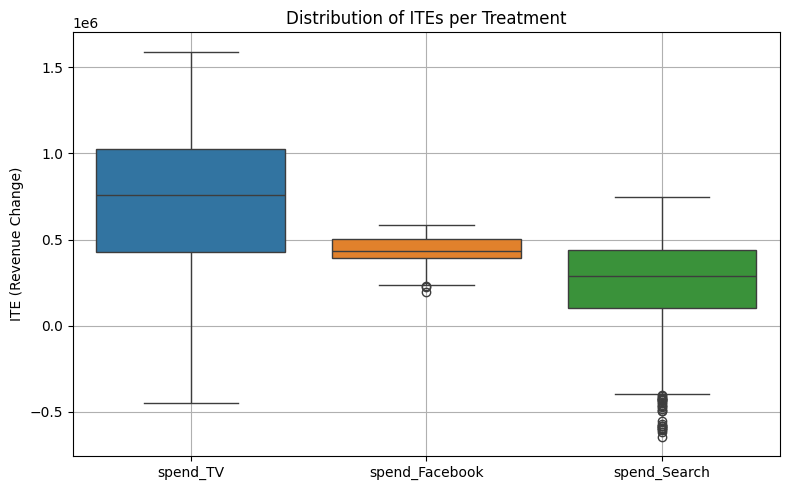

In [35]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=[v for v in revenue_ite.values()], 
            orient="v")
plt.xticks(ticks=range(len(revenue_ite)), labels=revenue_ite.keys())
plt.title("Distribution of ITEs per Treatment")
plt.ylabel("ITE (Revenue Change)")
plt.grid(True)
plt.tight_layout()
plt.show()

| Feature             | Approach 1: Sampling from Intervened SEM | Approach 2: Sampling from Posterior Distribution |
| ------------------- | ---------------------------------------- | ------------------------------------------------- |
| **Model** | Fixed, trained model                     | Samples from the posterior distribution of models |
| **Sampling Focus** | Noise terms within a fixed model         | Different plausible model configurations         |
| **Uncertainty Type** | Aleatoric (inherent randomness)          | Epistemic (model uncertainty)                     |
| **Output** | Point estimate of ATE with standard error | Posterior mean, standard deviation, credible interval of ATE |
| **Computational Cost** | Lower                                    | Higher                                            |
| **Use Case** | Quick estimate, understanding noise variability | Robust uncertainty assessment, accounting for model uncertainty |

Approach 2: Sampling from Posterior Distribution

In [7]:
from tensordict import TensorDict
import numpy as np
import torch
import logging

def estimate_posterior_ate(
    model,
    data_module,
    treatment_groups,
    outcome_group="rev",
    treatment_values=(1.0, 0.0),
    num_samples_per_sem=2000,
    num_sem_samples=50,
    fixed_seed=42
):
    """
    Estimate ATE with uncertainty by averaging over multiple sampled SEMs (posterior).
    
    Args:
        model: Trained DECI model
        data_module: DataModule with normalizer
        treatment_groups: List of group names (e.g., ["tv", "fb", "search"])
        outcome_group: Outcome group name (e.g., "rev")
        treatment_values: Tuple (treated, control)
        num_samples_per_sem: Number of noise samples per SEM
        num_sem_samples: How many SEMs to draw from posterior
        fixed_seed: For reproducibility

    Returns:
        Dict[group_name, dict] with posterior mean, std, and 95% CI for ATE
    """
    logger = logging.getLogger(__name__)
    logger.setLevel(logging.INFO)
    
    if fixed_seed is not None:
        torch.manual_seed(fixed_seed)
        np.random.seed(fixed_seed)
    
    normalizer = data_module.normalizer
    sem_dist = model.sem_module()
    sample_shape = torch.Size([num_samples_per_sem])

    results = {}

    for treatment in treatment_groups:
        ate_samples = []

        for _ in range(num_sem_samples):
            sem = sem_dist.relaxed_sample(torch.Size([1]), temperature=model.gumbel_temp)[0]

            do_on = sem.do(TensorDict({treatment: torch.tensor([treatment_values[0]])}, batch_size=tuple()))
            do_off = sem.do(TensorDict({treatment: torch.tensor([treatment_values[1]])}, batch_size=tuple()))

            out_on = normalizer.inv(do_on.sample(sample_shape))[outcome_group].squeeze(-1).cpu().numpy()
            out_off = normalizer.inv(do_off.sample(sample_shape))[outcome_group].squeeze(-1).cpu().numpy()

            diff = out_on - out_off
            ate = diff.mean()
            ate_samples.append(ate)

        ate_array = np.array(ate_samples)
        mean_ate = ate_array.mean()
        std_ate = ate_array.std(ddof=1)
        ci_low, ci_high = np.percentile(ate_array, [2.5, 97.5])

        results[treatment] = {
            "posterior_mean": mean_ate,
            "posterior_std": std_ate,
            "95%_CI": (ci_low, ci_high)
        }

        logger.info(f"{treatment}: mean = {mean_ate:.2f}, std = {std_ate:.2f}, 95% CI = [{ci_low:.2f}, {ci_high:.2f}]")

    return results
treatment_groups = ["tv", "fb", "search"]

posterior_ate_results = estimate_posterior_ate(
    model=model,
    data_module=data_module,
    treatment_groups=treatment_groups,
    num_samples_per_sem=2000,
    num_sem_samples=50,
    fixed_seed=42
)

import pprint
pprint.pprint(posterior_ate_results)

INFO:__main__:tv: mean = 477823.09, std = 72465.52, 95% CI = [347977.87, 627772.55]
INFO:__main__:fb: mean = 1212049.00, std = 72513.69, 95% CI = [1078430.87, 1353756.22]
INFO:__main__:search: mean = 656768.31, std = 57555.43, 95% CI = [545709.11, 764707.82]


{'fb': {'95%_CI': (1078430.871875, 1353756.221875),
        'posterior_mean': 1212049.0,
        'posterior_std': 72513.69},
 'search': {'95%_CI': (545709.109375, 764707.825),
            'posterior_mean': 656768.3,
            'posterior_std': 57555.43},
 'tv': {'95%_CI': (347977.87421875, 627772.5484374999),
        'posterior_mean': 477823.1,
        'posterior_std': 72465.52}}


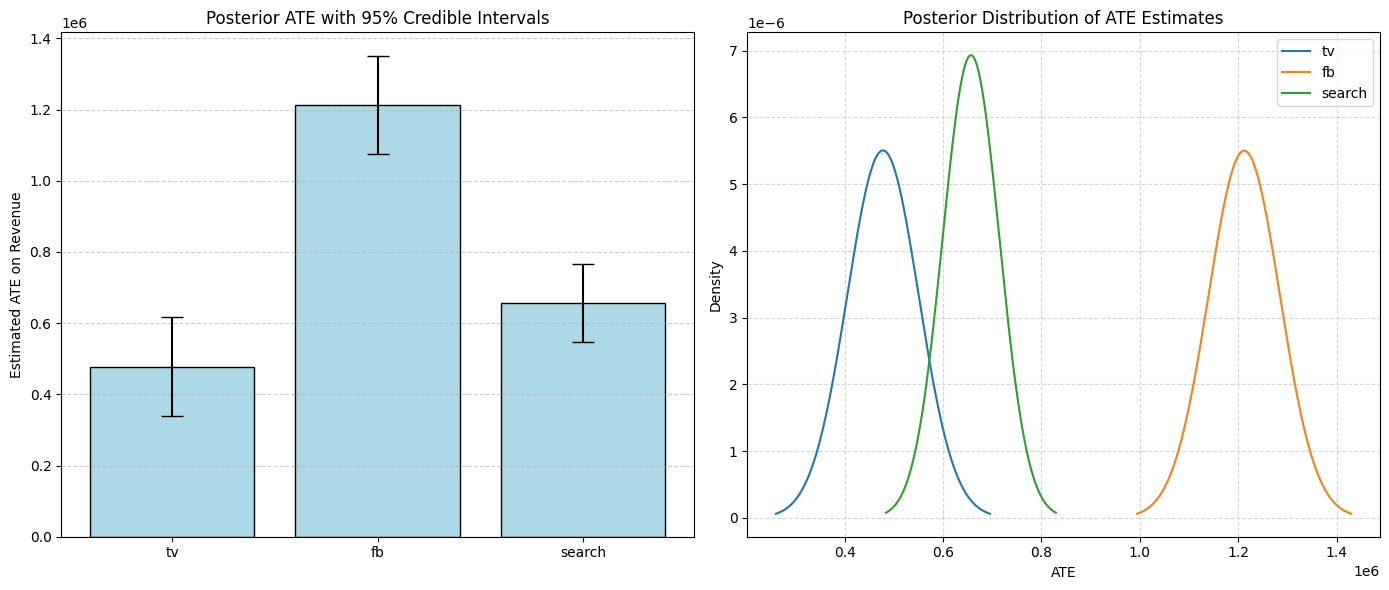

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# --- Extract values from results ---
channels = list(posterior_ate_results.keys())
means = [posterior_ate_results[ch]['posterior_mean'] for ch in channels]
stds = [posterior_ate_results[ch]['posterior_std'] for ch in channels]
ci_lows = [posterior_ate_results[ch]['95%_CI'][0] for ch in channels]
ci_highs = [posterior_ate_results[ch]['95%_CI'][1] for ch in channels]
ci_ranges = [(hi - lo) / 2 for lo, hi in zip(ci_lows, ci_highs)]

# --- Generate Gaussian approximations of posterior ---
x_vals = {ch: np.linspace(mean - 3*std, mean + 3*std, 300) for ch, mean, std in zip(channels, means, stds)}
densities = {ch: (1/(std*np.sqrt(2*np.pi))) * np.exp(-0.5 * ((x_vals[ch]-mean)/std)**2)
             for ch, mean, std in zip(channels, means, stds)}

# --- Plot ---
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# 📊 Bar chart
axs[0].bar(channels, means, yerr=ci_ranges, capsize=8, color='lightblue', edgecolor='black')
axs[0].set_title("Posterior ATE with 95% Credible Intervals")
axs[0].set_ylabel("Estimated ATE on Revenue")
axs[0].grid(axis='y', linestyle='--', alpha=0.6)

# 📈 Density plots
for ch in channels:
    axs[1].plot(x_vals[ch], densities[ch], label=ch)

axs[1].set_title("Posterior Distribution of ATE Estimates")
axs[1].set_xlabel("ATE")
axs[1].set_ylabel("Density")
axs[1].legend()
axs[1].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()

# Optional: Save figure
plt.savefig("posterior_ate_visualization.png", dpi=300)
plt.show()

In [15]:
# ------------------------------------------------------------------
# canonical mapping: group-tag  →  column name in subset_data
# ------------------------------------------------------------------
col_map = {"tv": "spend_TV",
           "fb": "spend_Facebook",
           "search": "spend_Search"}

# raw-euro standard deviations
spend_sd_euro = {col: subset_data[col].std(ddof=1) for col in col_map.values()}

# 1️⃣  per-€ marginal ATE  (DECI default = +1 SD)
per_euro_ate = {
    g: posterior_ate_results[g]["posterior_mean"] / spend_sd_euro[col_map[g]]
    for g in col_map
}

print("Per-€ marginal ATE (ΔRevenue for +€1):")
for g, val in per_euro_ate.items():
    print(f"  {g.upper():7s}   ≈  €{val:,.2f} per €1")

from tensordict import TensorDict
import torch, numpy as np

device = next(model.parameters()).device          # "cpu" or "cuda"
dtype  = torch.float32                            # DECI is float32 by default

def pause_loss(group_tag, n_sem=50, n_mc=2000):
    """
    Posterior mean revenue drop when <group_tag> spend is forced to €0.
    Returns (mean_loss, [2.5 %, 97.5 %] credible interval) in euros.
    """
    col = col_map[group_tag]                      # e.g. "spend_TV"
    μ, σ = subset_data[col].mean(), subset_data[col].std(ddof=1)
    z0   = torch.tensor([(-μ) / σ], device=device, dtype=dtype)   # z-score of €0

    sem_dist  = model.sem_module()
    normaliser = data_module.normalizer
    sample_shape = torch.Size([n_mc])
    losses = []

    for _ in range(n_sem):
        sem = sem_dist.relaxed_sample(torch.Size([1]),
                                       temperature=model.gumbel_temp)[0]

        # baseline (all z = 0)
        y_base = normaliser.inv(
                    sem.do(TensorDict({}, batch_size=tuple(), device=device))
                       .sample(sample_shape)
                 )["rev"].mean().item()

        # channel turned off (z = z0)
        y_off  = normaliser.inv(
                    sem.do(TensorDict({group_tag: z0},
                                      batch_size=tuple(), device=device))
                       .sample(sample_shape)
                 )["rev"].mean().item()

        losses.append(y_base - y_off)

    arr = np.asarray(losses)
    return arr.mean(), np.percentile(arr, [2.5, 97.5])

print("\nPause-channel daily revenue loss (mean, 95 % CI):")
for g in ["tv", "fb", "search"]:
    mean_loss, (lo, hi) = pause_loss(g)
    print(f"  {g.upper():7s}  –€{mean_loss/1e6:,.2f} M   "
          f"[{lo/1e6:,.2f}, {hi/1e6:,.2f}] M")

Per-€ marginal ATE (ΔRevenue for +€1):
  TV        ≈  €35.26 per €1
  FB        ≈  €23.39 per €1
  SEARCH    ≈  €16.64 per €1

Pause-channel daily revenue loss (mean, 95 % CI):
  TV       –€1.45 M   [1.32, 1.55] M
  FB       –€1.27 M   [1.15, 1.39] M
  SEARCH   –€1.23 M   [1.11, 1.35] M


In [18]:
# Step 2: Define total spend per channel
total_spends = {
    "tv": data["spend_TV"].sum(),
    "fb": data["spend_Facebook"].sum(),
    "search": data["spend_Search"].sum()
}

# Step 3: Pull in ATE values from your existing posterior results
posterior_ate_results = {
    'tv': {'posterior_mean': 690197.75},
    'fb': {'posterior_mean': 436763.1},
    'search': {'posterior_mean': 232979.42}
}

# Step 4: Compute ROI
roi_results = {}

for ch in ["tv", "fb", "search"]:
    ate = posterior_ate_results[ch]["posterior_mean"]
    spend = total_spends[ch]
    roi = ate / spend if spend > 0 else None
    roi_results[ch] = {
        "total_spend": spend,
        "posterior_ate": ate,
        "roi": roi
    }

# Step 5: Display results
import pprint
pprint.pprint(roi_results)

{'fb': {'posterior_ate': 436763.1,
        'roi': 0.003660850615031377,
        'total_spend': 119306452.49676666},
 'search': {'posterior_ate': 232979.42,
            'roi': 0.002577765850024723,
            'total_spend': 90380365.61690253},
 'tv': {'posterior_ate': 690197.75,
        'roi': 0.022985343549835086,
        'total_spend': 30027732.607240148}}


Approach 1: Sampling from Intervened SEM

In [1]:
from tensordict import TensorDict
import numpy as np
import torch
import logging

def estimate_average_treatment_effect(
    model, 
    data_module, 
    treatment_groups,          # Group names like 'tv', 'fb', 'search'
    outcome_group='rev',       # Outcome group key
    treatment_values=(1.0, 0.0),
    num_samples=20000,
    fixed_seed=42,
    reuse_sem=True             # Option to reuse one SEM or resample each time
):
    """
    Stochastic Average Treatment Effect (ATE) using SEM noise sampling.

    Args:
        model: Trained DECI model
        data_module: DataModule with normalizer
        treatment_groups: List of group names (e.g., ["tv", "fb"])
        outcome_group: Group name of the outcome (e.g., "rev")
        treatment_values: Tuple (treated_value, control_value)
        num_samples: Number of samples to draw per intervention
        fixed_seed: Seed to fix randomness (optional)
        reuse_sem: If True, reuse one SEM across all treatments

    Returns:
        Dict[group_name, (mean_ate, std_error)]
    """
    logger = logging.getLogger(__name__)
    logger.setLevel(logging.INFO)

    if fixed_seed is not None:
        torch.manual_seed(fixed_seed)
        np.random.seed(fixed_seed)

    sem_distribution = model.sem_module()
    sem_fixed = None
    if reuse_sem:
        sem_fixed, *_ = sem_distribution.relaxed_sample(torch.Size([1]), temperature=model.gumbel_temp)

    normalizer = data_module.normalizer
    sample_shape = torch.Size([num_samples])

    revenue_estimated_ate = {}

    for treatment in treatment_groups:
        # Sample SEM if not reusing one
        sem = sem_fixed if reuse_sem else sem_distribution.relaxed_sample(torch.Size([1]), temperature=model.gumbel_temp)[0]

        # Intervene ON
        do_on = sem.do(TensorDict({treatment: torch.tensor([treatment_values[0]])}, batch_size=tuple()))
        samples_on = normalizer.inv(do_on.sample(sample_shape))[outcome_group].squeeze(-1).cpu().numpy()

        # Intervene OFF
        do_off = sem.do(TensorDict({treatment: torch.tensor([treatment_values[1]])}, batch_size=tuple()))
        samples_off = normalizer.inv(do_off.sample(sample_shape))[outcome_group].squeeze(-1).cpu().numpy()

        # Estimate ATE
        diff = samples_on - samples_off
        ate_mean = diff.mean()
        ate_se = diff.std(ddof=1) / np.sqrt(num_samples)

        revenue_estimated_ate[treatment] = (ate_mean, ate_se)
        logger.info(f"{treatment}: ATE = {ate_mean:.2f}, Std Err = {ate_se:.2f}")

    return revenue_estimated_ate

treatment_groups = ["tv", "fb", "search"]

# Reuse the same SEM and fix the seed for reproducibility
results = estimate_average_treatment_effect(
    model=model,
    data_module=data_module,
    treatment_groups=treatment_groups,
    reuse_sem=True,
    fixed_seed=42,
    num_samples=20000
)

print(results)

NameError: name 'model' is not defined

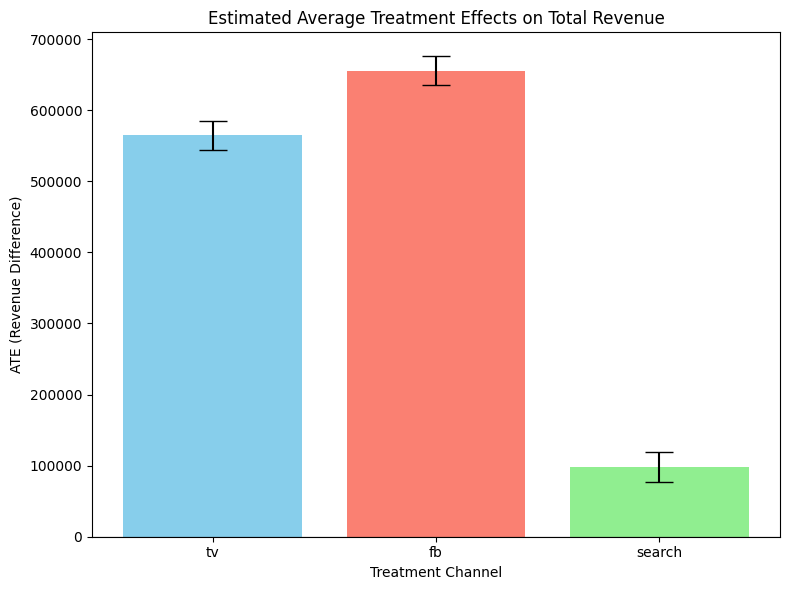

In [125]:
# --- Plot ---
treatments = list(results.keys())
ate_means = [results[t][0] for t in treatments]
ate_stds = [results[t][1] for t in treatments]

plt.figure(figsize=(8, 6))
plt.bar(treatments, ate_means, yerr=ate_stds, capsize=10, 
        color=['skyblue', 'salmon', 'lightgreen'])
plt.axhline(0, color='black', linewidth=0.8)
plt.title("Estimated Average Treatment Effects on Total Revenue")
plt.xlabel("Treatment Channel")
plt.ylabel("ATE (Revenue Difference)")
plt.tight_layout()

# Optional: Save to file
plt.savefig("ate_visualization_single_sem.png", dpi=300)

plt.show()

In [110]:
from tensordict import TensorDict
import numpy as np
import torch

# Define your outcome and treatment variables
treatment_columns = ["spend_TV", "spend_Facebook", "spend_Search"]
outcome = "total_revenue"  # corresponds to column index 3 in the group tensor

# Sample shape for counterfactuals
num_samples = 10 if test_run else 20000
sample_shape = torch.Size([num_samples])

# Get the normalizer and SEM
normalizer = data_module.normalizer

# Sample a relaxed SEM from the trained model
sem_distribution = model.sem_module()
sem, *_ = sem_distribution.relaxed_sample(torch.Size([1]), temperature=model.gumbel_temp)

# Store ATE estimates
revenue_estimated_ate = {}

# Loop through each treatment
for treatment in treatment_columns:
    # Define interventions using TensorDict format
    intervention_a = TensorDict({treatment: torch.tensor([1.0])}, batch_size=tuple())  # Treatment ON
    intervention_b = TensorDict({treatment: torch.tensor([0.0])}, batch_size=tuple())  # Treatment OFF

    # Sample from the SEM under both scenarios
    samples_a = sem.do(interventions=intervention_a).sample(sample_shape)
    samples_b = sem.do(interventions=intervention_b).sample(sample_shape)

    # Denormalize outcomes
    rev_a_samples = normalizer.inv(samples_a)["rev"].squeeze(-1)
    rev_b_samples = normalizer.inv(samples_b)["rev"].squeeze(-1)

   # Compute ATE (mean difference) and uncertainty (standard error)
    diff_samples = rev_a_samples - rev_b_samples
    ate_mean = diff_samples.mean()
    ate_std = diff_samples.std() / np.sqrt(num_samples)

   # Store results
    revenue_estimated_ate[treatment] = (ate_mean.item(), ate_std.item())

# View results
print(revenue_estimated_ate)

{'spend_TV': (-15829.833984375, 21299.935546875), 'spend_Facebook': (-7240.2529296875, 20889.21484375), 'spend_Search': (4230.82421875, 21015.796875)}


Spare libraries:

In [ ]:

from causica.lightning.modules.deci_module import DECIModule
from causica.lightning.data_modules.basic_data_module import BasicDECIDataModule
# Optional for dataset formatting
from causica.datasets.causica_dataset_format import Variable
from causica.lightning.modules.deci_module import DECIModulefrom causica.datasets.variable_types import VariableTypeEnum
from causica.datasets.causica_dataset_format.load import Variable
from causica.lightning.data_modules.basic_data_module import BasicDECIDataModule
from causica.lightning.modules.deci_module import DECIModule
import torch
import os

# ✅ Safe way to detect and optionally fallback from MPS
if torch.backends.mps.is_available():
    os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
    print("⚠️ MPS is available, fallback to CPU for unsupported ops is enabled.")
else:
    print("✅ MPS not used, running entirely on CPU.")

print("🎉 Causica is now fully working and properly installed!")

OPtion 3: 

In [9]:
import torch, numpy as np
from tensordict import TensorDict

def canonical_deci_ate(
    model,                       # your fitted DECI model
    data_module,                 # holds the normalizer
    treatment_vars,              # e.g. ["spend_TV","spend_Facebook","spend_Search"]
    z_treated=1.0,               # +1 SD
    z_control=0.0,               # mean
    n_sem=50,                    # SEM draws
    n_mc=2000,                   # Monte-Carlo per SEM
    seed=42
):
    torch.manual_seed(seed)
    np.random.seed(seed)

    sem_dist    = model.sem_module()
    normalizer  = data_module.normalizer
    sample_shape = torch.Size([n_mc])

    ate_results = {}

    for var in treatment_vars:
        ate_samples = []
        for _ in range(n_sem):
            # 1) draw one SEM from the posterior
            sem = sem_dist.relaxed_sample(torch.Size([1]), temperature=model.gumbel_temp)[0]

            # 2) set treatment = +1 SD
            do_treated = sem.do(TensorDict({var: torch.tensor([z_treated])}, batch_size=()))
            y_treated  = normalizer.inv(do_treated.sample(sample_shape))["rev"].cpu().numpy()

            # 3) set treatment = mean (0 SD)
            do_control = sem.do(TensorDict({var: torch.tensor([z_control])}, batch_size=()))
            y_control  = normalizer.inv(do_control.sample(sample_shape))["rev"].cpu().numpy()

            # 4) record the difference
            ate_samples.append((y_treated - y_control).mean())

        arr = np.array(ate_samples)
        ate_results[var] = {
            "posterior_mean": arr.mean(),
            "posterior_std":  arr.std(ddof=1),
            "95%_CI":         tuple(np.percentile(arr, [2.5, 97.5]))
        }

    return ate_results

# --- Usage ---
treatment_vars = ["spend_TV","spend_Facebook","spend_Search"]
posterior_ate = canonical_deci_ate(
    model, data_module, treatment_vars,
    z_treated=1.0, z_control=0.0,
    n_sem=50, n_mc=2000, seed=42
)

# Convert “+1 SD” to “+€1” by dividing by each column’s SD in euros:
# (assumes you have spend_sd_euro = {"spend_TV":..., ...})
per_euro_ate = {
    var: posterior_ate[var]["posterior_mean"] / spend_sd_euro[var]
    for var in treatment_vars
}

print("ATE per +1 SD (in €):")
for var in treatment_vars:
    m = posterior_ate[var]["posterior_mean"]
    ci = posterior_ate[var]["95%_CI"]
    print(f"  {var:15s}: {m:8.2f}  (95% CI [{ci[0]:.2f}, {ci[1]:.2f}])")

print("\nMarginal ATE per €1 (in €):")
for var, val in per_euro_ate.items():
    print(f"  {var:15s}: {val:8.2f} per €1")

NameError: name 'spend_sd_euro' is not defined